In [1]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [3]:
# get market info for bitcoin from the start of 2016 to the current day

social_media_info = pd.read_csv('cryptodata_social_cryptocompare.csv')
social_media_info.index

RangeIndex(start=0, stop=2001, step=1)

In [4]:
market_info = pd.read_csv('BTC-USD.csv')
market_info.index

RangeIndex(start=0, stop=2434, step=1)

In [5]:
# first 567 contains zeros
social_media_info = social_media_info[567:2001:1]

In [6]:
social_media_info.head()

,Unnamed: 0,comments,posts,followers,points,overview_page_views,analysis_page_views,markets_page_views,charts_page_views,trades_page_views,forum_page_views,influence_page_views,total_page_views,fb_likes,fb_talking_about,twitter_followers,twitter_following,twitter_lists,twitter_favourites,twitter_statuses,reddit_subscribers,reddit_active_users,reddit_posts_per_hour,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,code_repo_stars,code_repo_forks,code_repo_subscribers,code_repo_open_pull_issues,code_repo_closed_pull_issues,code_repo_open_issues,code_repo_closed_issues,code_repo_contributors,time
567,567,5634,2370,5851,261865,722156,53665,73188,141558,26634,66635,5206,1089042,31479,597,194066,105,2783,76,18775,230517,4748,23.10,554.38,351.56,8437.50,15817,9804,1765,229,8282,686,3537,0,5/26/2017
568,568,5827,2427,5990,268695,746321,54589,75038,146799,27456,69720,5292,1125215,31505,565,195011,105,2787,76,18781,231470,15977,13.78,330.62,172.08,4130.02,15853,9820,1766,234,8283,688,3539,0,5/27/2017
569,569,5873,2443,6090,272055,762354,55312,76280,151348,27911,71133,5352,1149690,31539,533,195817,105,2795,76,18787,232185,3070,14.01,336.20,138.09,3314.15,15876,9837,1766,234,8284,685,3543,0,5/28/2017
570,570,5896,2458,6199,275385,777977,55917,77388,154664,28556,72482,5397,1172381,31560,453,196623,105,2795,76,18793,232777,3448,15.27,366.41,267.86,6428.57,15904,9845,1770,235,8286,686,3545,0,5/29/2017
571,571,5958,2471,6318,279305,793113,56560,78481,158590,29580,73833,5447,1195604,31582,359,197387,105,2801,76,18799,233336,4480,18.80,451.25,278.21,6676.97,15932,9866,1778,234,8291,686,3546,0,5/30/2017


In [7]:
social_media_info = social_media_info.dropna(how='any',axis=0) 
social_media_info['time'] = pd.to_datetime(social_media_info['time'])
social_media_info = social_media_info.sort_values(by='time')

In [8]:
market_info = market_info.dropna(how='any',axis=0)
market_info['Date'] = pd.to_datetime(market_info['Date'])
market_info = market_info.sort_values(by='Date')

In [9]:
# social media first row's date is 2017-05-26, and last row's date is 2021-04-28
market_info = market_info[(market_info['Date'] >= '2017-05-26') & (market_info['Date'] <= '2021-04-28')]

In [10]:
# join 2 datasets into 1 over Date field
market_info = market_info[market_info['Date'].notnull() == True].set_index('Date')
social_media_info = social_media_info[social_media_info['time'].notnull() == True].set_index('time')
dataset = market_info.join(social_media_info, how='right')

In [47]:
dataset = dataset.loc[:, ~dataset.columns.str.contains('^Unnamed')]

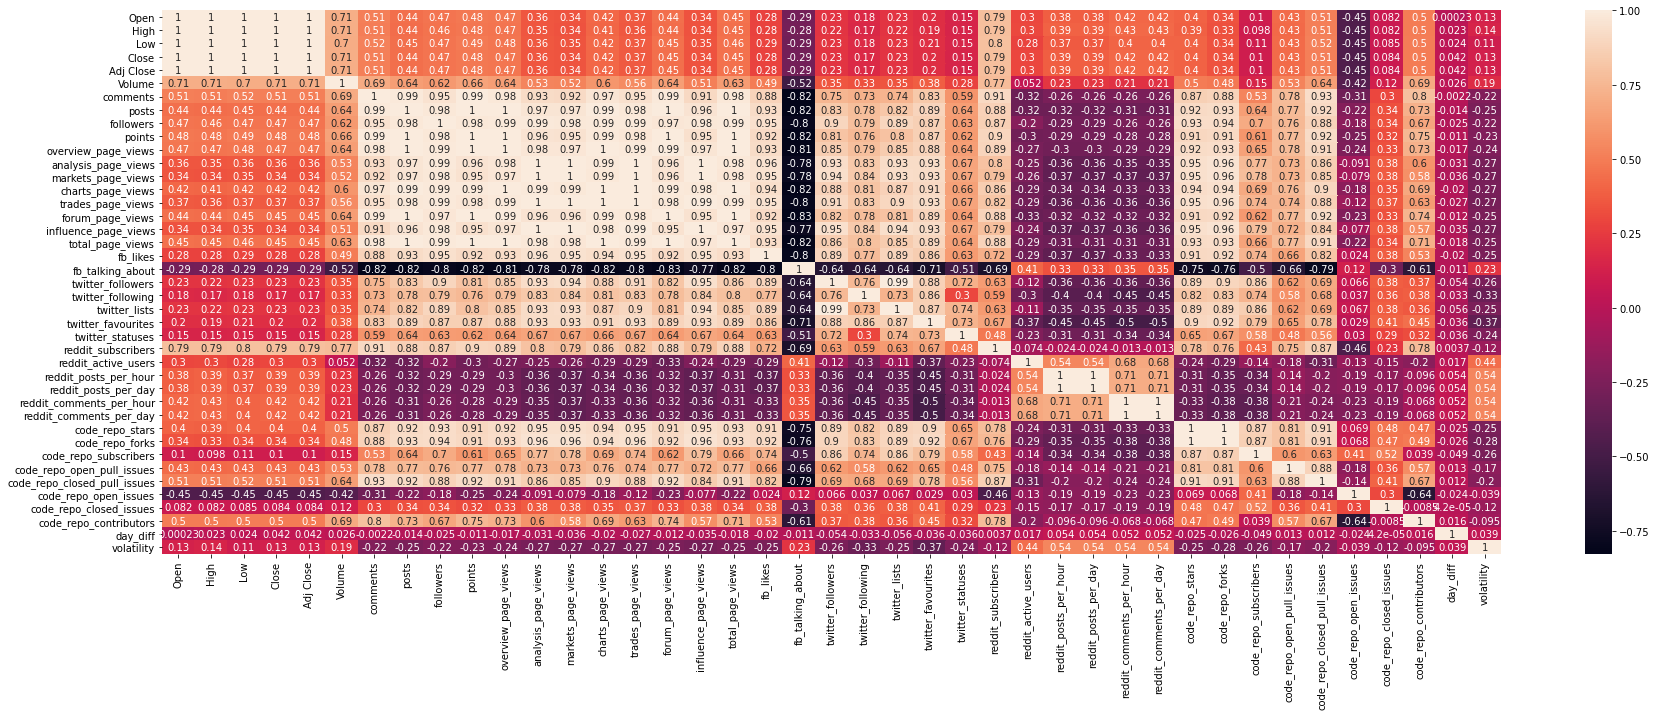

In [90]:
corrMatrix = dataset.corr()
plt.figure(figsize=(30,10))
sns.heatmap(corrMatrix, annot=True)
plt.show()

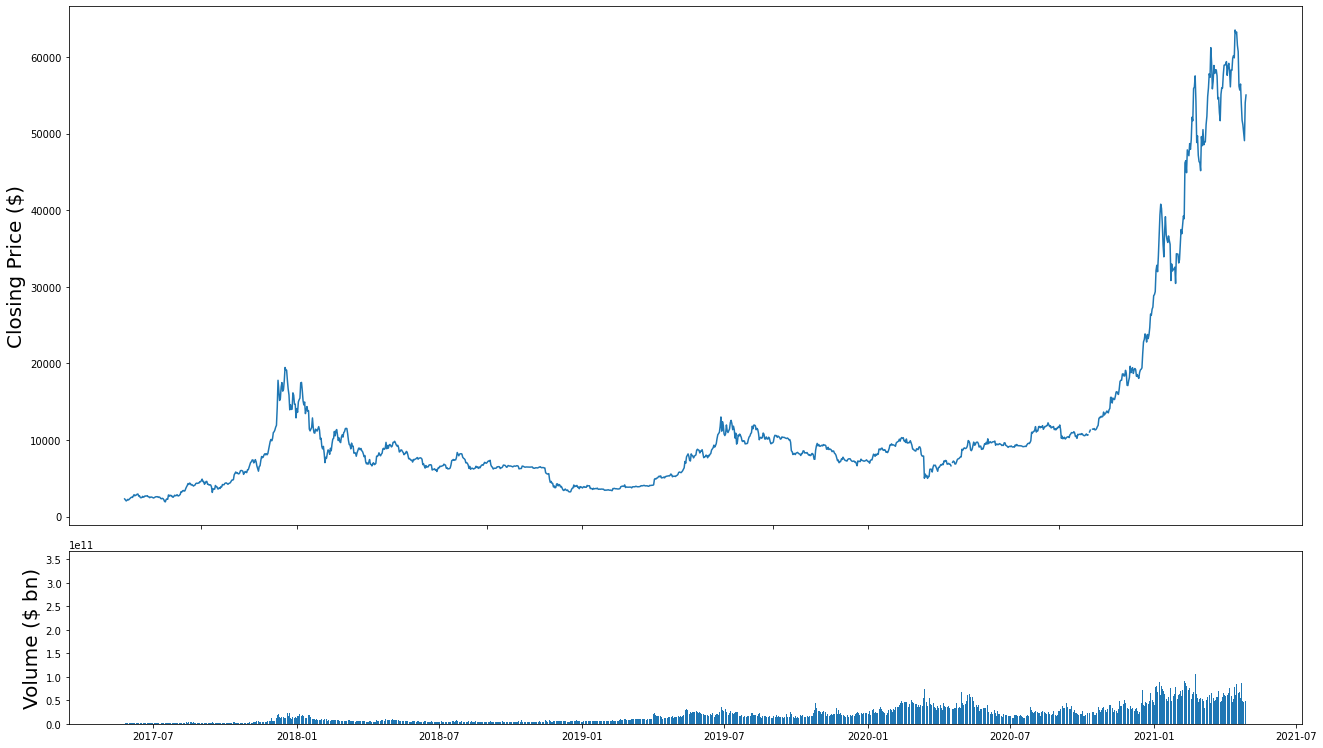

In [49]:
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
#ax1.set_yscale('log')
ax1.set_ylabel('Closing Price ($)',fontsize=20)
ax2.set_ylabel('Volume ($ bn)',fontsize=20)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2021) for j in [1,9]])
ax1.set_xticklabels('')
ax1.plot(dataset.index,dataset['Open'])
ax2.bar(dataset.index, dataset['Volume'].values)
fig.set_size_inches(18.5, 10.5)
fig.tight_layout()

plt.show()

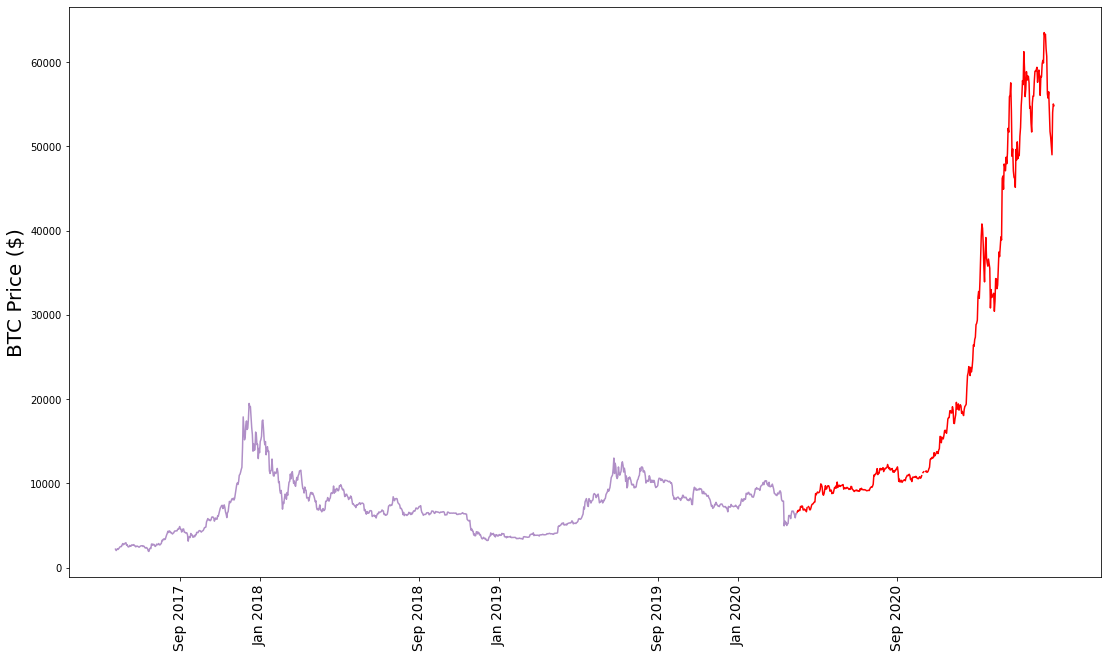

In [69]:
split_date = '2020-04-01'
fig, (ax2) = plt.subplots(1,1)
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2021) for j in [1,9]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2021) for j in [1,9]])
ax2.plot(dataset[dataset.index < split_date].index,
         dataset[dataset.index < split_date]['Close'], 
         color='#B08FC7')
ax2.plot(dataset[dataset.index >= split_date].index,
         dataset[dataset.index >= split_date]['Close'], color='red')
ax2.set_ylabel('BTC Price ($)',fontsize=20)
fig.set_size_inches(18.5, 10.5)
plt.xticks(fontsize=14, rotation=90)
plt.show()

In [70]:
kwargs = {'day_diff': lambda x: (x['Close']-x['Open'])/x['Open'],
          'volatility': lambda x: (x['High']- x['Low'])/(x['Open'])}
dataset = dataset.assign(**kwargs)

In [71]:
training_set, test_set = dataset[dataset.index <split_date], dataset[dataset.index >= split_date]

In [72]:
window_len = 10

In [73]:
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in ['Close','Volume']:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set['Close'][:-window_len].values)-1

In [74]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in ['Close','Volume']:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['Close'][window_len:].values/test_set['Close'][:-window_len].values)-1

In [75]:
# I find it easier to work with numpy arrays rather than pandas dataframes
# especially as we now only have numerical data
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [78]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dense(units=32))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [80]:
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
eth_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# model output is next price normalised to 10th previous closing price
LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set['Close'][:-window_len].values)-1
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
1031/1031 - 4s - loss: 0.1225
Epoch 2/50
1031/1031 - 3s - loss: 0.1186
Epoch 3/50
1031/1031 - 3s - loss: 0.1172
Epoch 4/50
1031/1031 - 2s - loss: 0.1173
Epoch 5/50
1031/1031 - 2s - loss: 0.1147
Epoch 6/50
1031/1031 - 2s - loss: 0.1163
Epoch 7/50
1031/1031 - 2s - loss: 0.1141
Epoch 8/50
1031/1031 - 2s - loss: 0.1135
Epoch 9/50
1031/1031 - 3s - loss: 0.1157
Epoch 10/50
1031/1031 - 2s - loss: 0.1129
Epoch 11/50
1031/1031 - 2s - loss: 0.1123
Epoch 12/50
1031/1031 - 2s - loss: 0.1130
Epoch 13/50
1031/1031 - 2s - loss: 0.1130
Epoch 14/50
1031/1031 - 2s - loss: 0.1119
Epoch 15/50
1031/1031 - 2s - loss: 0.1130
Epoch 16/50
1031/1031 - 2s - loss: 0.1125
Epoch 17/50
1031/1031 - 2s - loss: 0.1120
Epoch 18/50
1031/1031 - 2s - loss: 0.1115
Epoch 19/50
1031/1031 - 2s - loss: 0.1119
Epoch 20/50
1031/1031 - 2s - loss: 0.1112
Epoch 21/50
1031/1031 - 2s - loss: 0.1116
Epoch 22/50
1031/1031 - 2s - loss: 0.1113
Epoch 23/50
1031/1031 - 2s - loss: 0.1114
Epoch 24/50
1031/1031 - 3s - loss: 0.1093
E

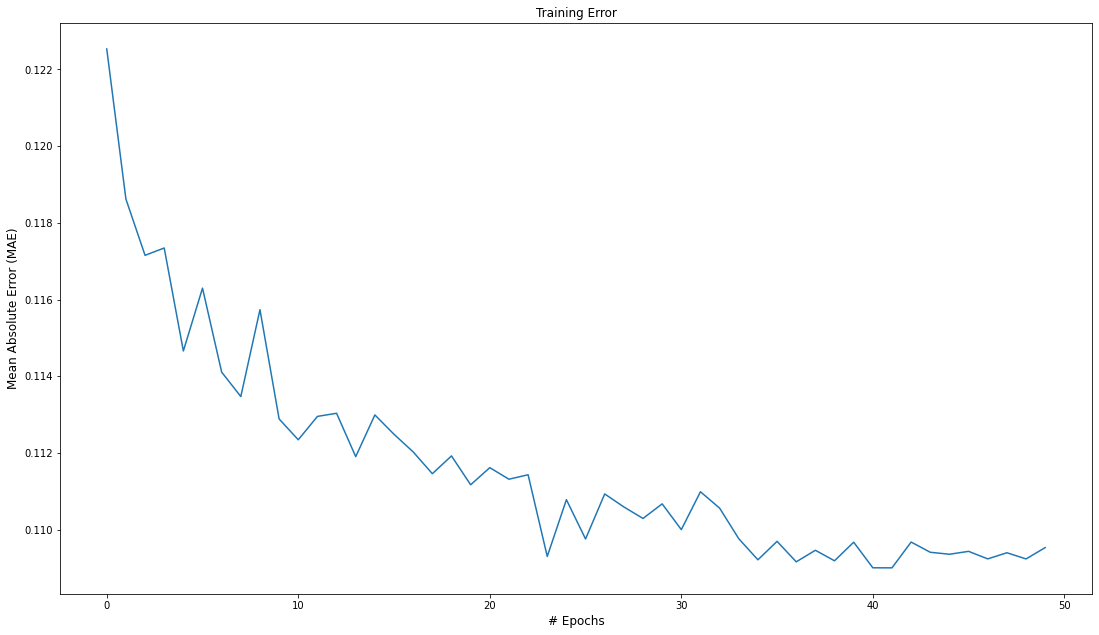

In [81]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(eth_history.epoch, eth_history.history['loss'])
ax1.set_title('Training Error')

if eth_model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# just in case you decided to change the model loss calculation
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)
fig.set_size_inches(18.5, 10.5)
plt.show()

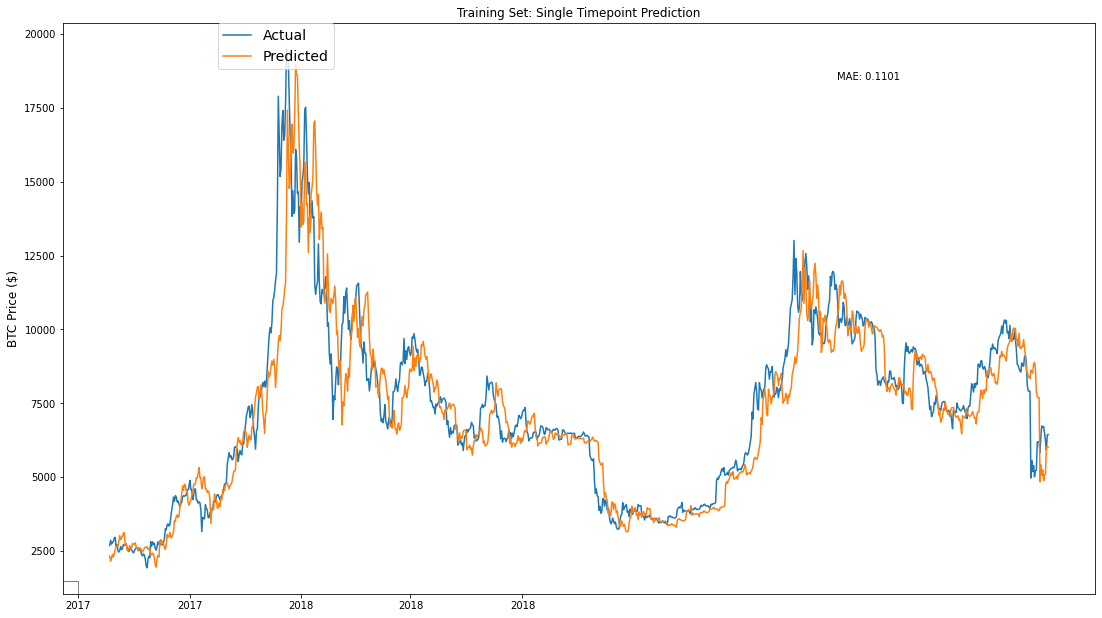

In [85]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
#ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2021) for j in [1,5,9]])
ax1.plot(dataset[dataset.index< split_date].index[window_len:],
         training_set['Close'][window_len:], label='Actual')
ax1.plot(dataset[dataset.index < split_date].index[window_len:],
         ((np.transpose(eth_model.predict(LSTM_training_inputs))+1) * training_set['Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('BTC Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_training_inputs))+1)-\
            (training_set['Close'].values[window_len:])/(training_set['Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
fig.set_size_inches(18.5, 10.5)
plt.show()


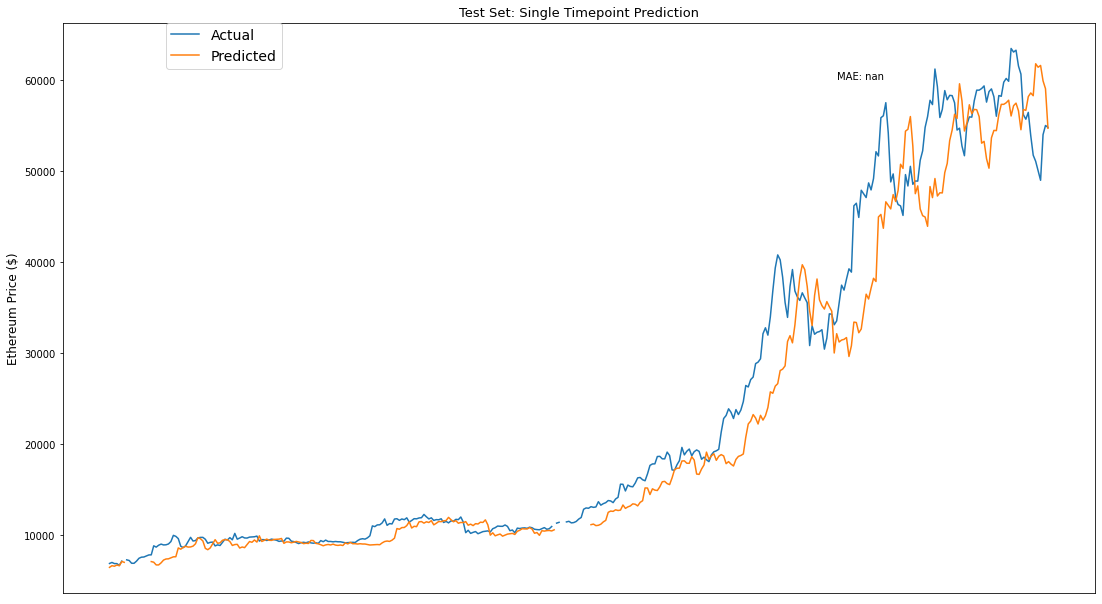

In [86]:
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(dataset[dataset.index>= split_date].index[window_len:],
         test_set['Close'][window_len:], label='Actual')
ax1.plot(dataset[dataset.index>= split_date].index[window_len:],
         ((np.transpose(eth_model.predict(LSTM_test_inputs))+1) * test_set['Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_test_inputs))+1)-\
            (test_set['Close'].values[window_len:])/(test_set['Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
fig.set_size_inches(18.5, 10.5)
plt.show()

In [87]:
# random seed for reproducibility
np.random.seed(202)
# we'll try to predict the closing price for the next 5 days 
# change this value if you want to make longer/shorter prediction
pred_range = 5
# initialise model architecture
eth_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)
# model output is next 5 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['Close'])-pred_range):
    LSTM_training_outputs.append((training_set['Close'][i:i+pred_range].values/
                                  training_set['Close'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
1026/1026 - 4s - loss: 0.1407
Epoch 2/50
1026/1026 - 3s - loss: 0.1325
Epoch 3/50
1026/1026 - 3s - loss: 0.1323
Epoch 4/50
1026/1026 - 3s - loss: 0.1315
Epoch 5/50
1026/1026 - 3s - loss: 0.1325
Epoch 6/50
1026/1026 - 3s - loss: 0.1301
Epoch 7/50
1026/1026 - 3s - loss: 0.1300
Epoch 8/50
1026/1026 - 3s - loss: 0.1292
Epoch 9/50
1026/1026 - 2s - loss: 0.1287
Epoch 10/50
1026/1026 - 2s - loss: 0.1280
Epoch 11/50
1026/1026 - 2s - loss: 0.1280
Epoch 12/50
1026/1026 - 2s - loss: 0.1283
Epoch 13/50
1026/1026 - 2s - loss: 0.1260
Epoch 14/50
1026/1026 - 2s - loss: 0.1265
Epoch 15/50
1026/1026 - 2s - loss: 0.1262
Epoch 16/50
1026/1026 - 2s - loss: 0.1259
Epoch 17/50
1026/1026 - 3s - loss: 0.1259
Epoch 18/50
1026/1026 - 2s - loss: 0.1254
Epoch 19/50
1026/1026 - 3s - loss: 0.1256
Epoch 20/50
1026/1026 - 2s - loss: 0.1254
Epoch 21/50
1026/1026 - 3s - loss: 0.1254
Epoch 22/50
1026/1026 - 2s - loss: 0.1253
Epoch 23/50
1026/1026 - 3s - loss: 0.1253
Epoch 24/50
1026/1026 - 2s - loss: 0.1250
E

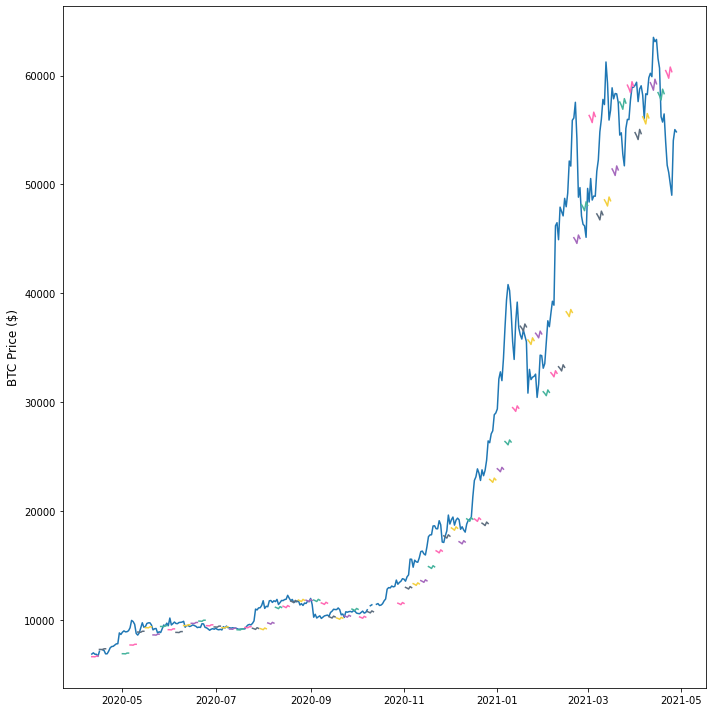

In [88]:
# little bit of reformatting the predictions to closing prices
eth_pred_prices = ((eth_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
                   test_set['Close'].values[:-(window_len + pred_range)][::5].reshape(int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))
pred_colors = ["#FF69B4", "#5D6D7E", "#F4D03F","#A569BD","#45B39D"]
fig, (ax2) = plt.subplots(1,1, figsize=(10, 10))

#ax2.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
#ax2.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax2.plot(dataset[dataset.index >= split_date].index[window_len:],
         test_set['Close'][window_len:], label='Actual')
for i, eth_pred in enumerate(eth_pred_prices):
    
    # Only adding lines to the legend once
    if i<5:
        ax2.plot(dataset[dataset.index>= split_date].index[window_len:][i*pred_range:((i*pred_range)+pred_range)],
                 eth_pred, color=pred_colors[i%5], label="Predicted")
    else: 
        ax2.plot(dataset[dataset.index>= split_date].index[window_len:][i*pred_range:i*pred_range+pred_range],
                 eth_pred, color=pred_colors[i%5])
ax2.set_ylabel('BTC Price ($)',fontsize=12)
fig.tight_layout()
plt.show()